In [3]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02a_machine_perception.ipynb"
_nb_title = "선형 모델을 사용해 꽃 이미지 분류하기"
_nb_message = """
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EC%84%A0%ED%98%95+%EB%AA%A8%EB%8D%B8%EC%9D%84+%EC%82%AC%EC%9A%A9%ED%95%B4+%EA%BD%83+%EC%9D%B4%EB%AF%B8%EC%A7%80+%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>선형 모델을 사용해 꽃 이미지 분류하기</h1>


# 선형 모델을 사용해 꽃 이미지 분류하기

크리에이티브 커먼즈 라이선스를 따르는 [꽃 사진 데이터셋](https://www.tensorflow.org/datasets/catalog/tf_flowers)의 3670개 이미지를 사용한다. 이미지들은 다음 다섯 가지 범주로 분류된다.
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', 'tulips'
</pre>
다음 주소의 Google Cloud Storage 공개 버킷에 준비해 두었다.
<pre>
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/
</pre>

이미지를 90% 데이터가 있는 훈련 세트와 10% 데이터가 있는 테스트 세트로 무작위로 분할해 CSV 파일에 나열했다.

- 훈련 세트: [train_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv)
- 평가 세트: [eval_set.csv](https://storage.cloud.google.com/practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv)


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [4]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


## 이미지를 살펴보기

train_set.csv의 처음 다섯 줄을 살펴보자.
각 줄에 JPEG 파일명과 꽃의 종류가 있다.

In [5]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # 파일 읽기
  img = tf.io.read_file(filename)
  # 압축된 문자열을 3D uint8 텐서로 변환
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # [0,1] 범위의 float로 변환
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 원하는 크기로 조정
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


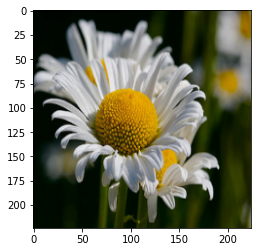

In [7]:
# 파일 한 개를 읽고 표시해 봄
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


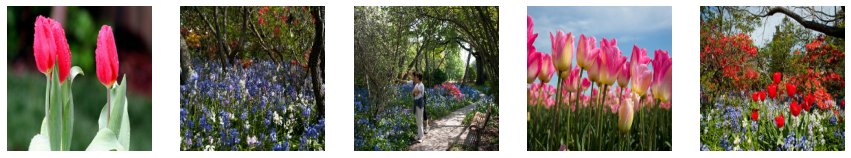

In [8]:
# 파일 경로명에 꽃 이름이 포함돼 있다. 튤립 사진을 몇 장 열어보자.
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [9]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

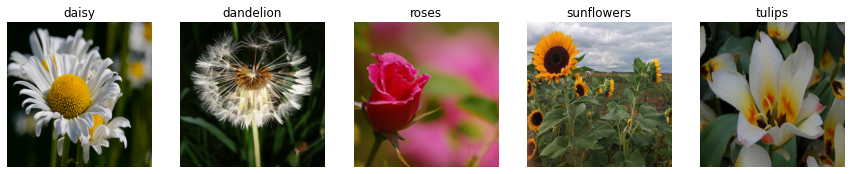

In [10]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

## 단순한 규칙 기반 모델

서로 다른 유형의 꽃에서 RGB 값의 평균 색상을 구한 다음, 알 수 없는 이미지를 가장 가까운 중심에 속하는 것으로 분류해 보자.

In [11]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # 이미지의 평균 픽셀
  print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


꽃 유형당 약 800개의 이미지가 있으므로 모든 이미지를 수행하면 시간이 걸린다. 데이터 처리 속도를 높이는 방법을 이 책의 뒷부분에서 살펴본다.

In [12]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0
  
  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # 이미지의 평균 픽셀
      self.centroids[label].update(avg)
  
  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # 이미지의 평균 픽셀
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label
  
  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

In [13]:
rule = CentroidRule()

# 전체 데이터셋을 열려면 .take(500)을 지워라.
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# 클래스들 간에 차이가 크지 않다.
print(rule.centroids['daisy'])
print(rule.centroids['roses'])

# 평가해 보자.
rule.evaluate(eval_dataset)

dandelion 100
tulips 100
daisy [0.44554377 0.44968468 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

무작위 뽑기나 다름 없다!

In [14]:
# 이것이 모델을 사용하여 예측하는 방법이다.
filename = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

tulips


## 선형 모델
각 픽셀에 다른 가중치를 적용하면 어떻게 될까?
Keras API를 사용해 보자.

In [15]:
# 레이블이 CLASS_NAMES 배열의 인덱스가 되도록 decode_csv가 변경됨
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

# 선형 모델
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


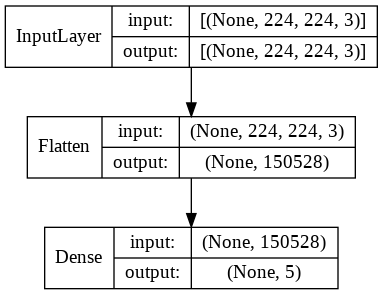

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [18]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 139s 414ms/step - loss: 16.3741 - accuracy: 0.3400 - val_loss: 29.5291 - val_accuracy: 0.3162
Epoch 2/10
330/330 [==============================] - 117s 355ms/step - loss: 15.9714 - accuracy: 0.4224 - val_loss: 11.7142 - val_accuracy: 0.4297
Epoch 3/10
330/330 [==============================] - 122s 369ms/step - loss: 11.6829 - accuracy: 0.4630 - val_loss: 13.4522 - val_accuracy: 0.4486
Epoch 4/10
330/330 [==============================] - 108s 328ms/step - loss: 12.1086 - accuracy: 0.4948 - val_loss: 17.6329 - val_accuracy: 0.4405
Epoch 5/10
330/330 [==============================] - 108s 328ms/step - loss: 12.2928 - accuracy: 0.5015 - val_loss: 32.7265 - val_accuracy: 0.3514
Epoch 6/10
330/330 [==============================] - 108s 326ms/step - loss: 13.7927 - accuracy: 0.5273 - val_loss: 31.8094 - val_accuracy: 0.3973
Epoch 7/10
330/330 [==============================] - 106s 320ms/step - loss: 15.4096 - accuracy: 0.5073 - val_l

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

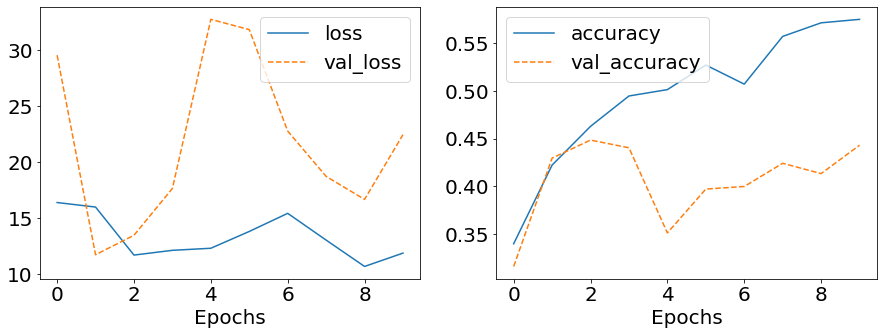

In [20]:
training_plot(['loss', 'accuracy'], history);

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.0721875  0.8794238 ]


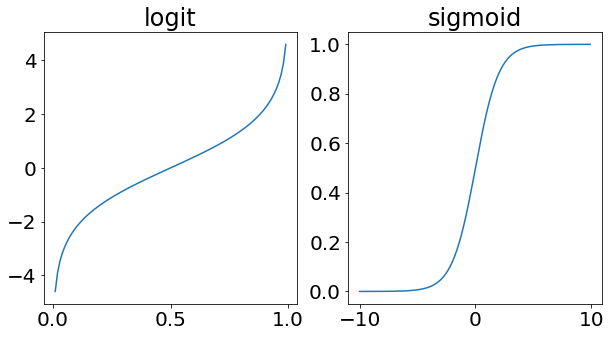

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

1/1 [==============================] - 0s 17ms/step


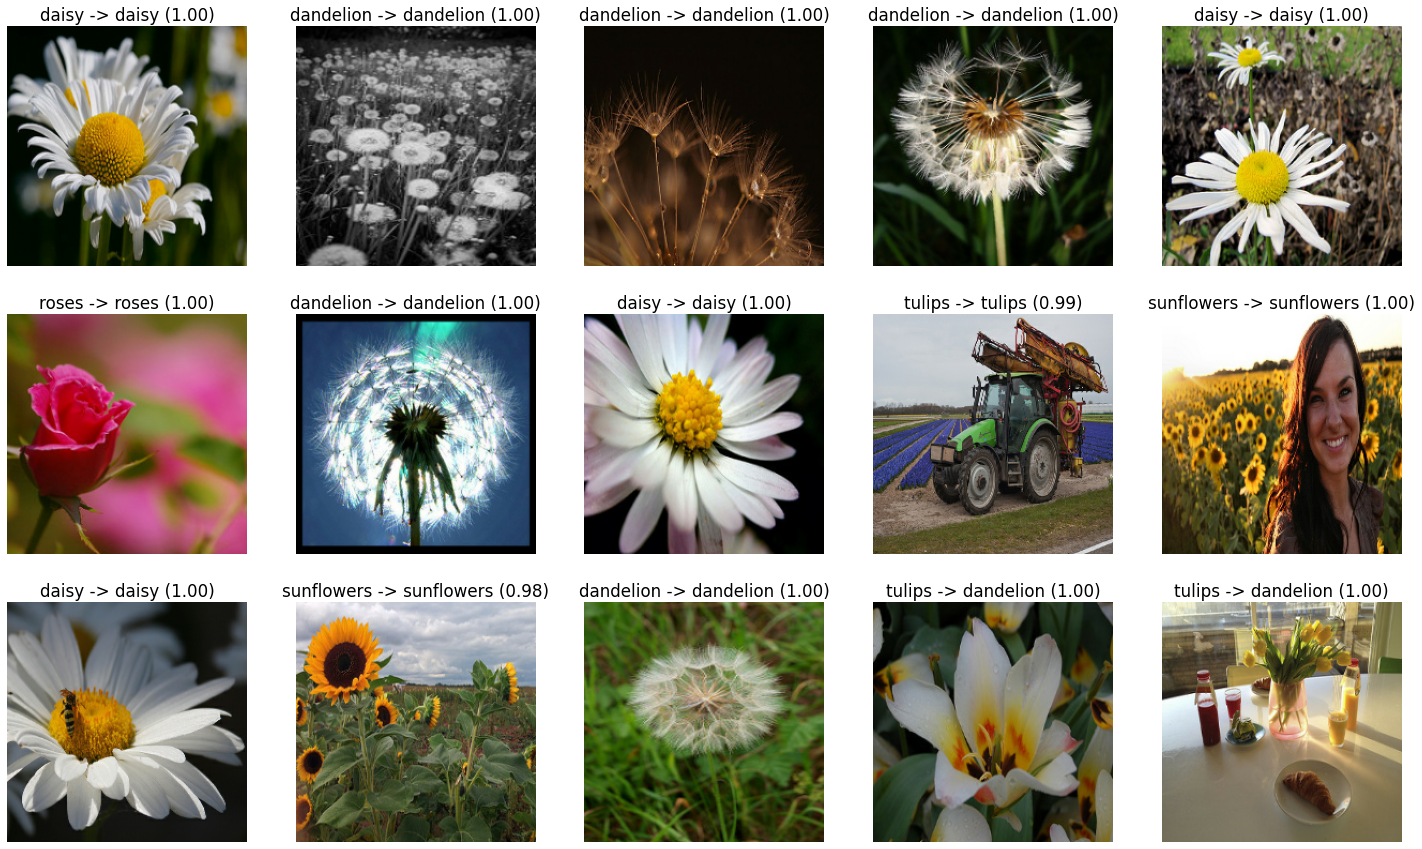

In [22]:
# 평가 데이터셋의 몇 가지 이미지에 대해 model.predict()를 호출.
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

1/1 [==============================] - 0s 19ms/step


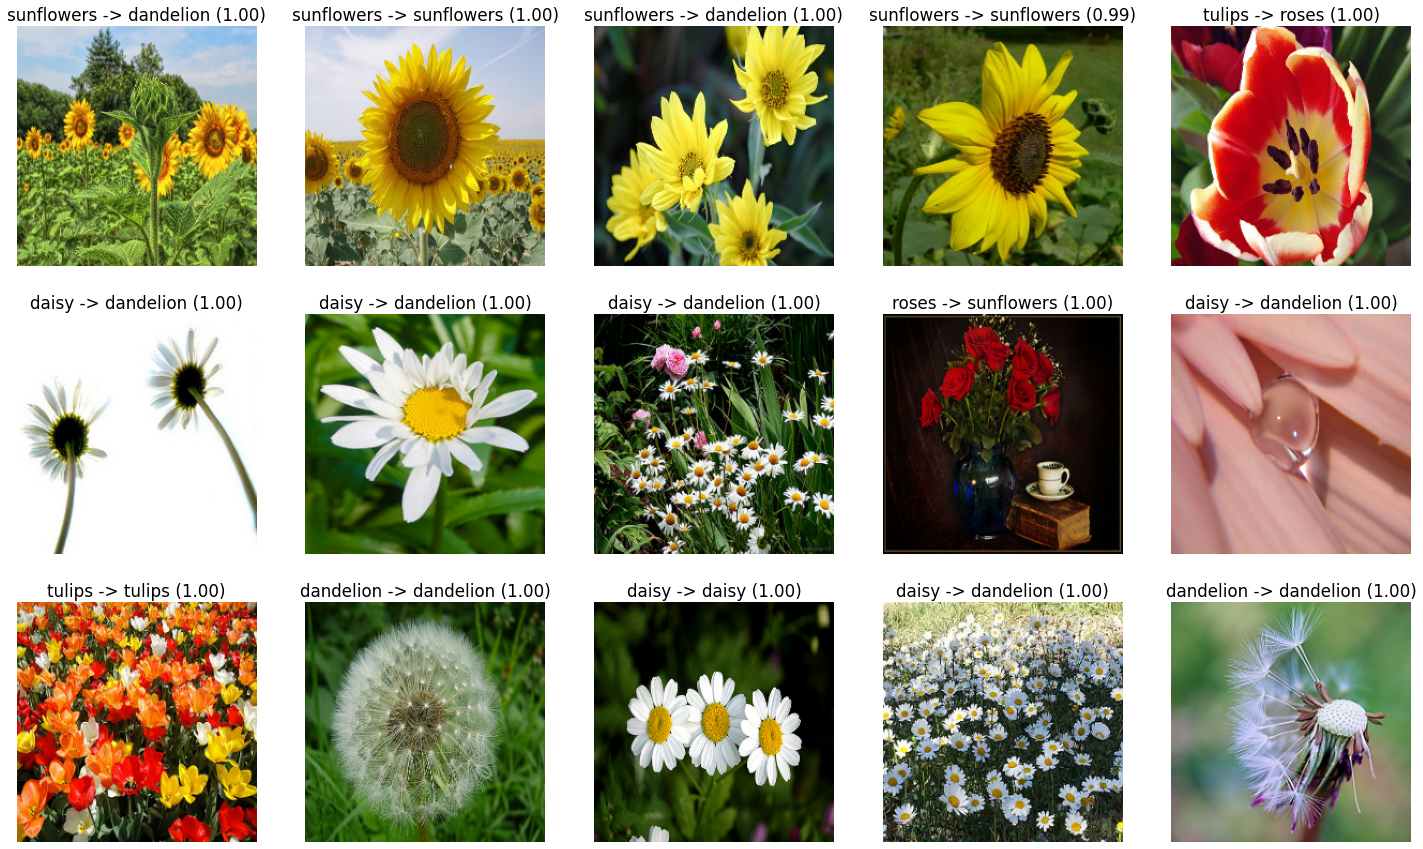

In [23]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

Scaling weights for daisy in -0.13672330975532532 to 0.11333749443292618
Scaling weights for dandelion in -0.11663640290498734 to 0.16129331290721893
Scaling weights for roses in -0.10593368113040924 to 0.11817779392004013
Scaling weights for sunflowers in -0.1645849049091339 to 0.1382579505443573
Scaling weights for tulips in -0.11703329533338547 to 0.11904072761535645


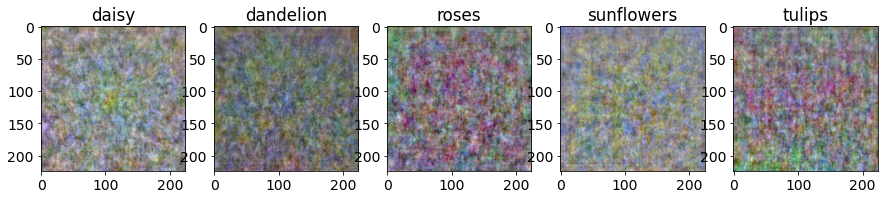

In [24]:
def show_trained_weights(model):
  # CLASS_NAMES은 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1  # 레이어 0은 이미지를 평탄화하며, layer=1은 첫 번째 덴스 레이어
  WEIGHT_TYPE = 0  # 0은 가중치, 1은 편향

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)

## 도표


[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.         0.20000002 0.6000001  0.20000002 0.        ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624455 0.48034936 0.06113537]
[0.12499999 0.12499999 0.49999997 0.12499999 0.12499999] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


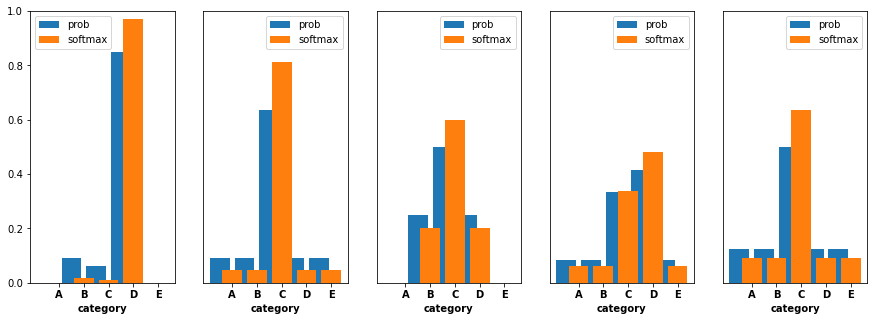

In [ ]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.